<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 8 - XGBoost Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[XGBoost Classifier with Simple Features](#xgb-simple)  
[XGBoost Classifier with Full Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the XGBoost classifier to the Indonesia dataset and explore how having an unbalanced dataset impacts the classifier performance. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'xgb'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# XGBoost with simple features <a class="anchor" id="xgb-simple"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.

In [3]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


In [4]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.39 s
CPU times: user 145 ms, sys: 3.08 ms, total: 148 ms
Wall time: 146 ms
In-sample score: 91.10%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/

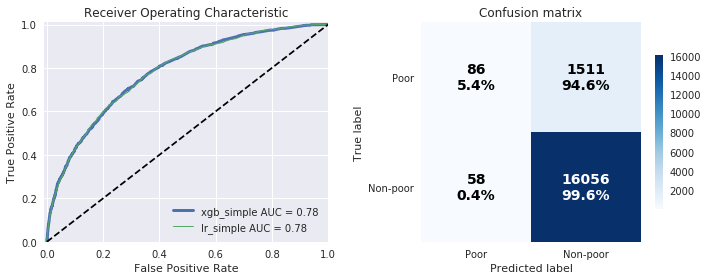

,xgb_simple,lr_simple
accuracy,0.911411,0.91158
recall,0.053851,0.0851597
precision,0.597222,0.564315
f1,0.0987938,0.147987
cross_entropy,0.256817,0.256817
roc_auc,0.782269,0.781848
cohen_kappa,0.0851478,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 0.60% 


In [5]:
from xgboost import XGBClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = XGBClassifier()
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [6]:
feat_imps

,importance
der_nchild10under,0.212857
der_nliterate,0.184286
der_nfemalesover10,0.178571
der_nmalesover10,0.148571
der_nemployedpast3mo,0.090000
hld_toilet__None,0.052857
hld_lighting__PLN electricity,0.050000
cons_029__Yes,0.041429
cons_054__Yes,0.041429


# XGBoost with all features <a class="anchor" id="all-feats"></a>

Now let's apply the XGBoost classifier to the dataset with all features. 

CPU times: user 41.3 s, sys: 593 ms, total: 41.9 s
Wall time: 41.9 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 456 ms, sys: 252 ms, total: 708 ms
Wall time: 703 ms
In-sample score: 90.59%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


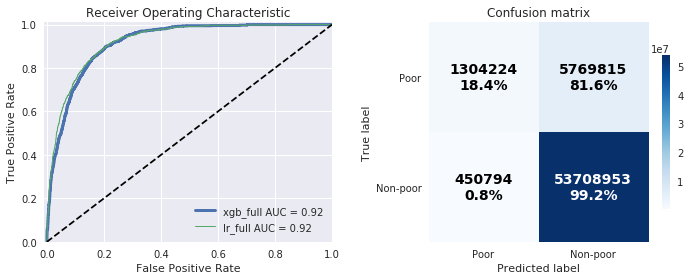

,xgb_full,lr_full
accuracy,0.898412,0.910251
recall,0.184368,0.456232
precision,0.74314,0.661838
f1,0.295439,0.540131
cross_entropy,0.22428,0.212947
roc_auc,0.917406,0.923198
cohen_kappa,0.284804,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 3.16% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = XGBClassifier()
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

X shape after undersampling:  (9584, 453)
CPU times: user 7.25 s, sys: 43.8 ms, total: 7.3 s
Wall time: 7.3 s
CPU times: user 53.9 ms, sys: 19.8 ms, total: 73.7 ms
Wall time: 72.4 ms
In-sample score: 87.26%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 162 ms, sys: 99.7 ms, total: 262 ms
Wall time: 260 ms
CPU times: user 197 ms, sys: 56.2 ms, total: 253 ms
Wall time: 252 ms


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


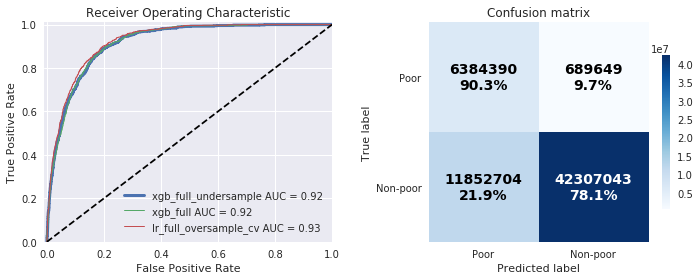

,xgb_full_undersample,xgb_full,lr_full_oversample_cv
accuracy,0.795173,0.898412,0.851611
recall,0.90251,0.184368,0.838116
precision,0.350077,0.74314,0.427456
f1,0.504473,0.295439,0.566159
cross_entropy,0.409429,0.22428,0.348544
roc_auc,0.917304,0.917406,0.925356
cohen_kappa,0.376189,0.284804,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 29.49% 


In [8]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = XGBClassifier()
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test.as_matrix())
%time y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['xgb_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Oversampling <a class="anchor" id="oversampling">

X shape after oversampling:  (96680, 453)
CPU times: user 1min 21s, sys: 641 ms, total: 1min 22s
Wall time: 1min 22s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 553 ms, sys: 192 ms, total: 745 ms
Wall time: 743 ms
In-sample score: 95.59%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 170 ms, sys: 88.1 ms, total: 258 ms
Wall time: 256 ms
CPU times: user 169 ms, sys: 84.1 ms, total: 253 ms
Wall time: 251 ms


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


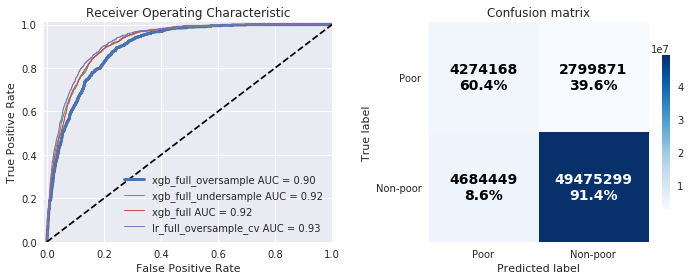

,xgb_full_oversample,xgb_full_undersample,xgb_full,lr_full_oversample_cv
accuracy,0.877775,0.795173,0.898412,0.851611
recall,0.604205,0.90251,0.184368,0.838116
precision,0.477101,0.350077,0.74314,0.427456
f1,0.533183,0.504473,0.295439,0.566159
cross_entropy,0.284027,0.409429,0.22428,0.348544
roc_auc,0.898701,0.917304,0.917406,0.925356
cohen_kappa,0.454867,0.376189,0.284804,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 8.72% 


In [9]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = XGBClassifier()
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test.as_matrix())
%time y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['xgb_full_undersample',
                                                    'xgb_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>


X shape after undersampling:  (9584, 453)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8691345151199166, total=  13.3s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.0s remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8759124087591241, total=  13.1s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8710855949895616, total=  13.2s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8810020876826722, total=  13.1s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8747390396659708, total=  13.0s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.872784150156413, total=  20.9s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8738269030239834, total=  20.7s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8789144050104384, total=  20.7s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8825678496868476, total=  20.7s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.9min finished


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8695198329853863, total=  20.8s
CPU times: user 13min 2s, sys: 1.14 s, total: 13min 3s
Wall time: 3min 19s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 551 ms, sys: 20 ms, total: 571 ms
Wall time: 569 ms
In-sample score: 96.71%
Best model parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1430, 'silent': 0, 'subsample': 0.8}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


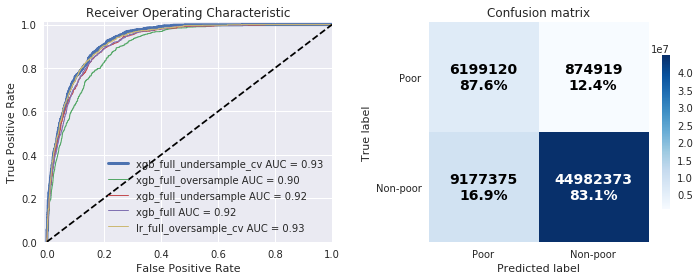

,xgb_full_undersample_cv,xgb_full_oversample,xgb_full_undersample,xgb_full,lr_full_oversample_cv
accuracy,0.835837,0.877775,0.795173,0.898412,0.851611
recall,0.87632,0.604205,0.90251,0.184368,0.838116
precision,0.403156,0.477101,0.350077,0.74314,0.427456
f1,0.552247,0.533183,0.504473,0.295439,0.566159
cross_entropy,0.366854,0.284027,0.409429,0.22428,0.348544
roc_auc,0.928831,0.898701,0.917304,0.917406,0.925356
cohen_kappa,0.453724,0.454867,0.376189,0.284804,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 25.33% 


In [10]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = XGBClassifier()
parameters = {'max_depth': np.arange(3,6,2),
              'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000],
              'seed': [1430]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=5)
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['xgb_full_oversample', 
                                                    'xgb_full_undersample',
                                                    'xgb_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)
best_model = model.best_estimator_

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

In [11]:
feat_imps.head(20)

,importance
geo_district,0.096450
der_hhsize,0.057870
geo_subdistrict,0.039167
geo_village,0.033739
der_nchild10under,0.016503
hld_nbcell,0.012469
der_nemployedpast3mo,0.012102
der_nliterate,0.011809
der_nfemalesover10,0.011075
cons_298__Yes,0.011002


# Feature selection <a class="anchor" id="feature-selection"></a>

X shape after feature selection:  (53132, 172)
X shape after undersampling:  (9584, 172)
CPU times: user 41.5 s, sys: 71.8 ms, total: 41.6 s
Wall time: 10.4 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 602 ms, sys: 3.93 ms, total: 606 ms
Wall time: 602 ms
In-sample score: 97.07%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


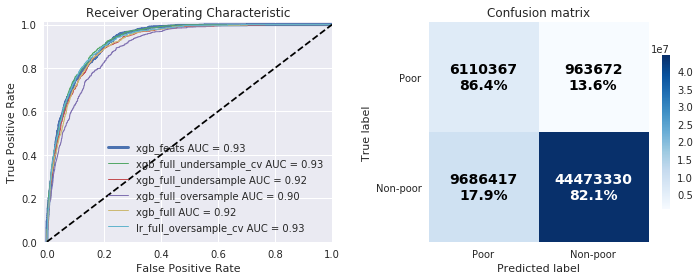

,xgb_feats,xgb_full_undersample_cv,xgb_full_undersample,xgb_full_oversample,xgb_full,lr_full_oversample_cv
accuracy,0.826075,0.835837,0.795173,0.877775,0.898412,0.851611
recall,0.863773,0.87632,0.90251,0.604205,0.184368,0.838116
precision,0.386811,0.403156,0.350077,0.477101,0.74314,0.427456
f1,0.534337,0.552247,0.504473,0.533183,0.295439,0.566159
cross_entropy,0.394871,0.366854,0.409429,0.284027,0.22428,0.348544
roc_auc,0.925672,0.928831,0.917304,0.898701,0.917406,0.925356
cohen_kappa,0.435116,0.453724,0.376189,0.454867,0.284804,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 25.75% 


In [12]:
feats = feat_imps[feat_imps.cumsum() <= 0.90].dropna().index.values

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
cols = X_train.columns
print("X shape after feature selection: ", X_train.shape)

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = best_model
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['xgb_full_undersample_cv',
                                                    'xgb_full_undersample',
                                                    'xgb_full_oversample', 
                                                    'xgb_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='feats', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [13]:
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

119 consumables features selected:
Transport expenses
Clove filter cigarettes
Powdered/bean coffee
Expenses on gasoline
Instant noodle
School fee
Buildings and land taxes
A plate of rice accompanied by a mixture of dishes
Broiler egg
Other spice
Self treatment/take medicine without recipe
Swamp cabbage
Treatment of skin, face, nails, hair
Chillies
Clove non filter cigarettes
Other drinks (coffee, milk, etc) 
Coconut
Lubricant
Stationery (pen, pencil, eraser, ruler, calculator, dividers, etc)
Cassava leaf
Fried food
Tea
Other prepared food
String bean
Noodle (with meatball/boiled/fried)
Pepper
Other fresh fish
Gasoline/pertamax
Pork
Footwear
Cosmetic articles and sanitary napkin
Tofu, soybean curd
Textbooks, photocopies of learning materials
Cayenne pepper
Soya sauce
Fermented soybean cake
Snack for children
Mobile phone bill
Spinach
Contraception cost
Cane sugar
Ready-made clothes for men
Other preserved fish
LPG Value
Cigarettes
Monosodium glutamate
Motor vehicle's service and repair


# Decision Trees Indonesia Summary <a class="anchor" id="summary"></a>



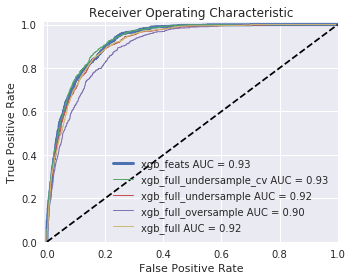

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
xgb_feats,0.826075,0.863773,0.386811,0.534337,0.394871,0.925672,0.435116,0.143749
xgb_full_undersample_cv,0.835837,0.87632,0.403156,0.552247,0.366854,0.928831,0.453724,0.139476
xgb_full_undersample,0.795173,0.90251,0.350077,0.504473,0.409429,0.917304,0.376189,0.181144
xgb_full_oversample,0.877775,0.604205,0.477101,0.533183,0.284027,0.898701,0.454867,-0.0265645
xgb_full,0.898412,0.184368,0.74314,0.295439,0.22428,0.917406,0.284804,-0.0822224


In [14]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)